# Определение критериев для продвижения игр в интернет-магазине "Стримчик"

# Описание проекта

Имеются исторические данные интернет-магазина "Стримчик" о продажах компьютерных игр, оценки пользователей и экспертов, жанры и платформы. Данные до 2016 года.

**Задача:** Выявить определяющие успешность игры закономерности, позволяющие сделать ставку на потенциально популярный продукт и спланировать рекламные кампании на 2017 год.


**Описание данных**:
*	Name — название игры
*	Platform — платформа
*	Year_of_Release — год выпуска
*	Genre — жанр игры
*	NA_sales — продажи в Северной Америке (миллионы проданных копий)
*	EU_sales — продажи в Европе (миллионы проданных копий)
*	JP_sales — продажи в Японии (миллионы проданных копий)
*	Other_sales — продажи в других странах (миллионы проданных копий)
*	Critic_Score — оценка критиков (максимум 100)
*	User_Score — оценка пользователей (максимум 10)
*	Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.


# План исследования

1. Изучение общей информации о данных.

2. Подготовка данных:
* Приведение названий столбцов к единому стилю
* Преобразование данных в нужные типы
* Обработка пропусков
* Добавление столбца с суммарными продажами во всех регионах.

3. Исследовательский анализ:
* Количество выпущенных игр в разные годы
* Подажи по платформам
* Определение актуального периода для исследования
* Динамика продаж по платформам
* Влияние на продажи отзывов пользователей и критиков.
* Прибыльность жанров

4. Портрет пользователя каждого региона:
* Самые популярные платформы в регионах
* Самые популярные жанры в регионах
* Влияние рейтинга ESRB на продажи в отдельном регионе

5. Проверка гипотез:
* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
* Средние пользовательские рейтинги жанров Action и Sports разные

6. Выводы исследоваия

## Изучение общей информации о данных

Импортируем библиотеки, выведем первые строки датасета и сводную информацию о нём.

In [2]:
#Импортирование библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

In [3]:
#Чтение файла с данными
data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

#Вывод первых строк
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
#Вывод сводной инфрмации о датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
#проверка на явные дубликаты
print('Явных дубликатов в датасете:', data.duplicated().sum())

Явных дубликатов в датасете: 0


**Выводы:**

1. В исходном датафрейме 10 колонок, 16715 записей
2. Названия колонок требуют приведение к единому стилю
3. Есть колонки с пропущенными значениями, большая их доля - в колонках с рейтингами
4. Не все типы данных колонок соотвествуют их содержанию  

## Предобработка данных

### Приведение названий столбцов к единому стилю

Чтобы привести названия столбцов к snake_case, достаточно привести их к нижнему регистру.

In [5]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Преобразование типов данных и обработка пропусков:


Выведем процент пропусков в столбцах:

In [6]:
na_counts = (
    pd.DataFrame(
        (data.isnull().sum()), 
        columns=['na_count'])
)
na_counts['na_percent'] = data.isnull().mean()*100

display(na_counts.sort_values(by='na_percent', ascending=False)\
.style.background_gradient(cmap='coolwarm'))

print('Общее количество строк:', data.shape[0])

,na_count,na_percent
critic_score,8578,51.319174
rating,6766,40.478612
user_score,6701,40.089740
year_of_release,269,1.609333
name,2,0.011965
genre,2,0.011965
platform,0,0.000000
na_sales,0,0.000000
eu_sales,0,0.000000
jp_sales,0,0.000000


Общее количество строк: 16715


#### Столбец **year_of_release**

Преобразуем тип данных **float -> int** для корректного отображения значений. Для этого предварительно необходимо обработать пустые значения в этом столбце. Подходящий алгоритм для автоматического заполнения пустых значений здесь отсутствует. Учитывая, что доля таких строк около 1.6%, можем их удалить, а затем преобразовать тип данных в **int**: 

In [7]:
#заменим пустые значения в столбце year_of_release на 0:
data.dropna(subset=['year_of_release'], inplace=True)

#приведём столбец year_of_release к типу int
data.loc[data['year_of_release'].notnull(), 'year_of_release'] = \
data.loc[data['year_of_release'].notnull(), 'year_of_release'].astype('int')
data.year_of_release.head()

0    2006
1    1985
2    2008
3    2009
4    1996
Name: year_of_release, dtype: int64

#### Столбец **user_score**


Необходимо преобразовать **object -> float** для последующего применения методов, работающих с числами. Однако, столбец содержит не только числа, что по всей видимости и явилось причиной того, что данный столбец имеет тип **object**:

In [8]:
data.user_score.sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

Значение **"tbd" ("to be decided")** могло проставляться в том случае, если рейтинг не определён, например, есть некоторое количество оценок пользователей, но его ещё не достаточно, чтобы объявить рейтинг. 

Возможности проверить это предположение и, например, запросить предварительный рейтинг по соответствующим играм, у нас нет. Поэтому будем считать, что пользовательский рейтинг в этих строках неизвестен, как и в других 6 тысячах строк с пустыми значениями в столбце с рейтингом.

Таким образом, чтобы получить возможность преобразовать столбец в тип **"float"**, предварительно изменим значение **"tbd"** на **None**.

In [9]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = None
data.user_score.sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', nan, None], dtype=object)

In [10]:
#приведём столбец user_score к типу данных 'float'
data.user_score = data.user_score.astype('float')
data.user_score.head()

0    8.0
1    NaN
2    8.3
3    8.0
4    NaN
Name: user_score, dtype: float64

#### Столбцы **name** и **genre**

Строк с пустыми значениями в столбцах **name** и **genre** всего две, можем удалить:

In [11]:
data = data.query('name.notnull() and genre.notnull()')
data.shape[0]

16444

#### Столбцы **year_of_release**, **user_score**, **critic_score**

Пустых строк с годом релиза в столбце **year_of_release** не так много, но оставим их как есть, поскольку алгоритм для автоматического заполнения отсутствует, а удалять их нецелесообразно: далее при определении целевого периода для исследования они в любом случае не войдут в исследуемый срез.

Пустые строки в столбцах **user_score**, **critic_score** так же оставляем, поскольку заполнение их синтетическими данными исказло бы статистику, а в случае их удаления мы лишились бы большой доли данных для анализа.

#### Столбец **rating**

В данном столбце содержится инфрмация о возрастном рейтинге. Заменим пропуски, означающие его отсутствие, на значение "Unknown":  

In [12]:
data.rating = data.rating.fillna('Unknown')

Выведем итоговые данные по пропускам:

In [13]:
na_counts = (
    pd.DataFrame(
        (data.isnull().sum()), 
        columns=['na_count'])
)
na_counts['na_percent'] = data.isnull().mean()*100

display(na_counts.sort_values(by='na_percent', ascending=False)\
.style.background_gradient(cmap='coolwarm'))

print('Общее количество строк:', data.shape[0])

,na_count,na_percent
user_score,8981,54.615665
critic_score,8461,51.453418
name,0,0.000000
platform,0,0.000000
year_of_release,0,0.000000
genre,0,0.000000
na_sales,0,0.000000
eu_sales,0,0.000000
jp_sales,0,0.000000
other_sales,0,0.000000


Общее количество строк: 16444


### Добавление столбца с суммарными продажами во всех регионах.

В данных отсутствует столбец с суммарными продажами. Добавим его.

In [14]:
data['total_sales'] = data.na_sales + data.eu_sales + data.jp_sales + data.other_sales
data.iloc[:,[4,5,6,7,-1]].head()

,na_sales,eu_sales,jp_sales,other_sales,total_sales
0,41.36,28.96,3.77,8.45,82.54
1,29.08,3.58,6.81,0.77,40.24
2,15.68,12.76,3.79,3.29,35.52
3,15.61,10.93,3.28,2.95,32.77
4,11.27,8.89,10.22,1.00,31.38


### Выводы по результатам предобработки данных

1.	Для приведения стиля к snake_case называния столбцов приведены к нижнему регистру.
2.	Для двух игр не были указаны название и жанр. Эти строки удалены.
3.	В столбце с годом выпуска пропущены 269 значений. Для приведения типа данных к **int** они заполнены значениями «0», в дальнейшем исследовании учитываться не будут. 
4.	Столбец с пользовательским рейтингом помимо пропусков содержал текстовые значения **tbd**, в рамках нашего исследования равнозначные отсутствию рейтинга. Для приведения типа данных в столбце к **float** были заменены на пустые значения.
5.	Возрастой рейтинг не проставлен в 40% случаев, в половине игр отсутствуют оценки экспертов или пользовательский рейтинг. При исследовании рейтинга данные строки учитываться не будут.
6.	Для дальнейшего исследования в датасет добавлен столбец с суммарными продажами по всем регионам.

In [15]:
# Комментарий ревьюера
# Посмотрим, что у нас осталось
temp = data.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,' : кол-во 0', temp[temp[col_l] == 0][col_l].count(),
        ', процент 0', round(temp[temp[col_l] == 0][col_l].count()/len(temp)*100, 2),'%')
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: float64(7), int64(1), object(4)
memory usage: 1.6+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
n

## Исследовательский анализ данных

### Количество выпущенных игр в разные годы

Выведем количество игр, выпущенных в разные годы

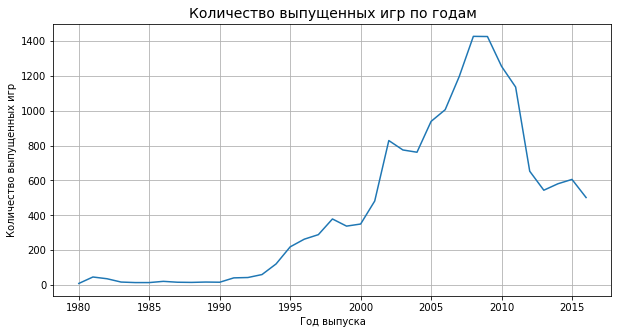

In [16]:
plt.figure(figsize=(10,5))
plt.plot(data.groupby('year_of_release')['name'].count())
plt.grid(True)
plt.title('Количество выпущенных игр по годам', size=14)
plt.xlabel('Год выпуска')
plt.ylabel('Количество выпущенных игр')
plt.show()

Количество выпускаемых игр начало существенно расти с 1995 года.\
Наибольшее количество выпущено в 2000-х, при этом пик пришёлся на 2008-2009 годы, когда выпускалось более 1400 игр в год.\
С 2010 года количество выпускаемых игр перешло к снижению и после 2012 года стабилизировалось в районе 500-600 игр в год.

### Определение актуального временного периода

Определим Топ-10 платформ с наибольшими суммарными продажами:

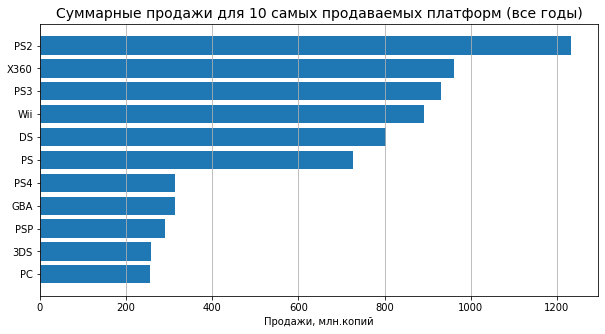

,platform,total_sales
10,PC,255.76
9,3DS,257.81
8,PSP,289.53
7,GBA,312.88
6,PS4,314.14
5,PS,727.58
4,DS,802.78
3,Wii,891.18
2,PS3,931.34
1,X360,961.24


In [17]:
top_sales_platforms = (
    data.groupby('platform').agg({'total_sales' : 'sum'})
    .sort_values(by='total_sales', ascending=False)
    .head(11)
    .reset_index()
    .sort_values(by='total_sales')
)

plt.figure(figsize=(10,5))
plt.barh(top_sales_platforms.platform, top_sales_platforms.total_sales)
plt.title('Суммарные продажи для 10 самых продаваемых платформ (все годы)', size=14)
plt.xlabel('Продажи, млн.копий')
plt.grid(axis='x')
plt.show()

top_sales_platforms

Посмотрим на распределение продаж для данных платформ по времени

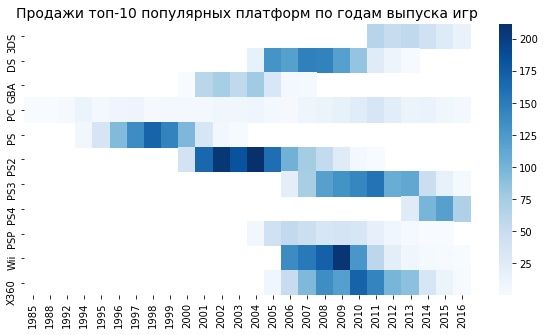

In [19]:
data = data.query('not(platform == "DS" and year_of_release == 1985)')

top_sales_years = (
    data.query('platform.isin(@top_sales_platforms.platform) and year_of_release > 0')
    .pivot_table(index='platform', 
                 columns='year_of_release', 
                 values='total_sales', 
                 aggfunc='sum')
)

plt.figure(figsize=(10,5))
ax = sns.heatmap(top_sales_years, cmap='Blues')
ax.set_title('Продажи топ-10 популярных платформ по годам выпуска игр', size=14)
ax.set(xlabel=None, ylabel=None)
plt.show()

Видим, что в данных содержатся игры с платформой DS, год выпуска которых датируется 1985 годом. Платформа DS впервые поступила в продажу в 2004 году, в связи с чем считаем эти данные ошибкой и удаляем соответствующие строки. Выводим график заново:

Период роста спроса на наиболее попуряные платформы (за исключеним PC, где спрос всегда относительно стабилен) составляет около 4-5 лет, около 2-3 лет - пик спроса, далее поисходит спад, который составляет около 5-6 лет.

Цикл "жизни" на платформы с точки зрения спроса обычно составляет около 10 лет.

Определим актуальный для исследования период с 2012 года. Количество выпускаемых игр с этого года стабильно, в то же время период в 5 лет позволит сделать выводы о том, на каком этапе "жизни" находятся актуальные платформы. В дальнейшем анализе будем в то же время учитывать, что данные за 2016 год могут быть не полными.

Сделаем соответствующий срез данных.

In [20]:
new_data = data.query('year_of_release >= 2012')
display(new_data.head())
print('Количество строк:', new_data.shape[0])

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,Unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,Unknown,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79


Количество строк: 2886


### Продажи игр по платформам

Выведем количество продаж по платформам с 2012 года. При этом при рассмотрении продаж в динамике 2016 год в расчёт не берём, поскольку данные по нему могут быть неполными)

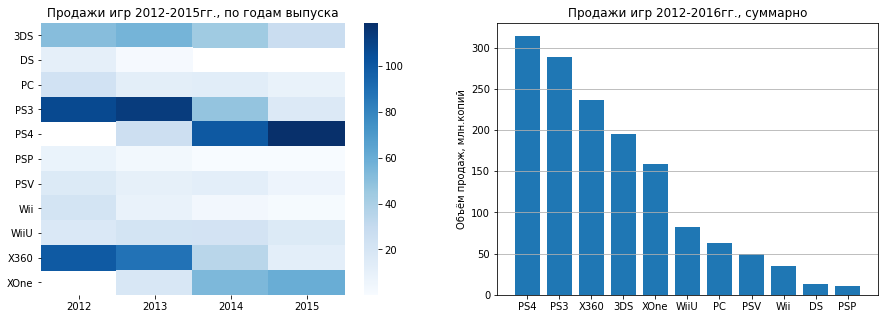

In [21]:
#формируем сводные таблицы
new_platform_total_sales = (new_data.groupby('platform')['total_sales'].sum()
                            .sort_values(ascending=False)
                            .reset_index()
                           )

new_platform_sales = new_data.pivot_table(index='platform', 
                                          columns='year_of_release', 
                                          values='total_sales', 
                                          aggfunc='sum')

#рисуем графики
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
ax = sns.heatmap(new_platform_sales.iloc[:,0:4], cmap='Blues')
ax.set_title('Продажи игр 2012-2015гг., по годам выпуска', size=12)
ax.set(xlabel=None, ylabel=None)

plt.subplot(1,2,2)
plt.bar(new_platform_total_sales.platform, new_platform_total_sales.total_sales)
plt.title('Продажи игр 2012-2016гг., суммарно', size=12)
plt.grid(axis='y')
plt.ylabel('Объём продаж, млн.копий')
plt.show()

По графикам видно, что платформа **PS3** пользовалась самой большой среди других платформ популярностью до 2014 года, но с этого момента уступила место своему преемнику **PS4**, последняя и является лидером продаж, причём от года к году продажи растут и можно предположить, что в 2017 году эта платформа останется самой перспективной.

Вторая платформа, которая находится в первой половине своего жизненного цикла продаж - **XOne**, к концу исследуемого периода она уступает по объёмам продаж только лидеру, **PS4**.

Платформы **3DS, WiiU, X360** также отличаются высокими продажами, но их динамика уже несколько лет отрицательная, жизненный цикл подходит к концу.

Отдельно стоит отметить платформу **PC** - у неё наблюдаем относительно небольшие продажи и постепенное их дальнейшее снижение, однако, в исторической перспективе подобные колбания не влияли на "живучесть" платформы в течение долгих лет. Из чего делаем вывод, что, с одной стороны, ожидать от неё взлётов не стоит, но и вряд ли в перспективе продажи сильно упадут.

Построим, как распределяются показатели продаж игр на разных платформах:

Посмотрим, как влияют на продажи внутри популярной платформы **XOne** отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.

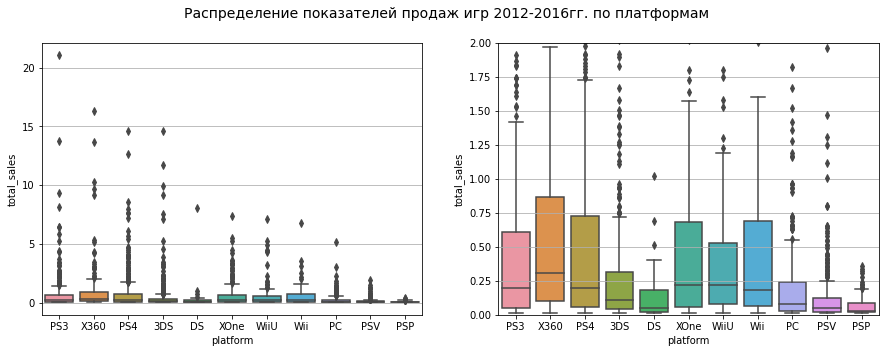

In [22]:
plt.figure(figsize=(15,5))
plt.suptitle('Распределение показателей продаж игр 2012-2016гг. по платформам', size=14)
plt.subplot(1,2,1)
ax = sns.boxplot(data=new_data, x='platform', y='total_sales')
plt.grid(axis='y')

plt.subplot(1,2,2)
ax = sns.boxplot(data=new_data, x='platform', y='total_sales')
plt.ylim(0,2)
plt.grid(axis='y')
plt.show()

Наибольшее количество игр с высокими продажами приходится на платформы X360, XOne, PS3, PS4, Wii, WiiU. Это подтверждает выводы, сделанные выше, относительно наиболее перспективных с точки зрения продаж платформ.

### Влияние на продажи отзывов пользователей и критиков

Исследуем влияние на продажи отзывов. Для этоо построим диаграммы рассеяния и рассчитаем корреляцию для пяти платформ с наибольшим количеством отзывов.

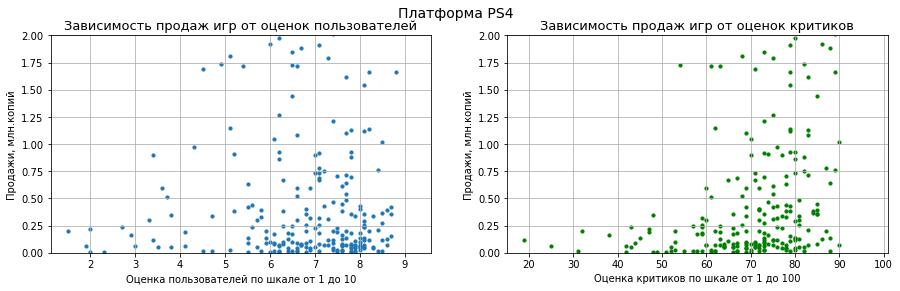

Коэффициент корреляции продаж и оценок пользователей: -0.03
Коэффициент корреляции продаж и оценок критиков: 0.41


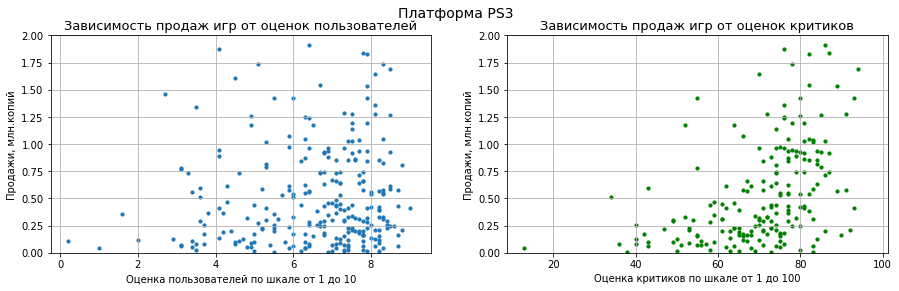

Коэффициент корреляции продаж и оценок пользователей: -0.01
Коэффициент корреляции продаж и оценок критиков: 0.33


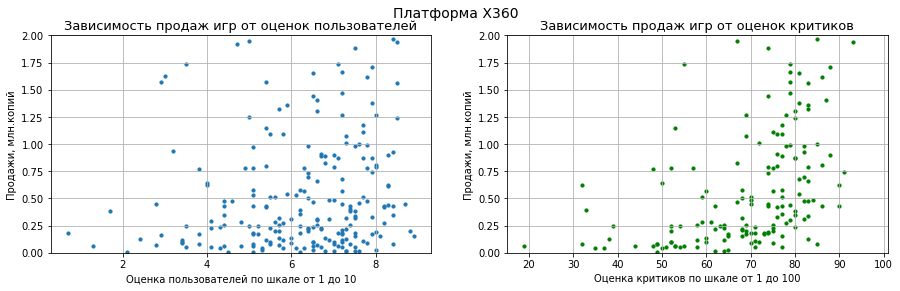

Коэффициент корреляции продаж и оценок пользователей: 0.01
Коэффициент корреляции продаж и оценок критиков: 0.36


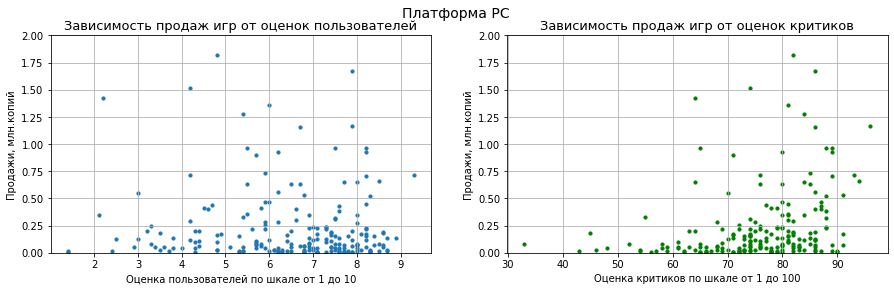

Коэффициент корреляции продаж и оценок пользователей: -0.12
Коэффициент корреляции продаж и оценок критиков: 0.24


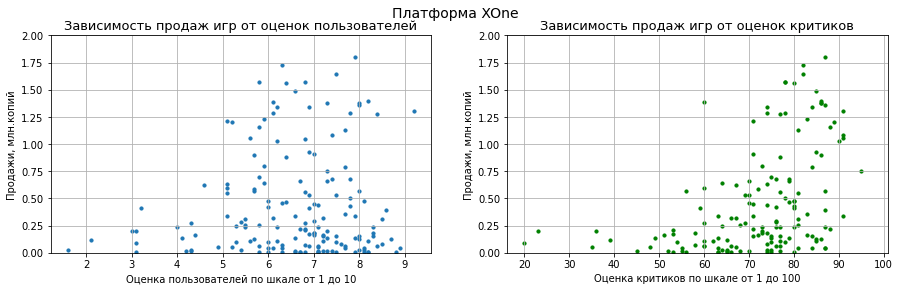

Коэффициент корреляции продаж и оценок пользователей: -0.07
Коэффициент корреляции продаж и оценок критиков: 0.42


In [23]:
def platform_score_plots(platform):
    platform_data = new_data.query('platform == @platform')
    plt.figure(figsize=(15,4))
    plt.suptitle(f'Платформа {platform}', size=14)
    plt.subplot(1,2,1)
    plt.scatter(x=platform_data.user_score, y=platform_data.total_sales, s=10)
    plt.title('Зависимость продаж игр от оценок пользователей', size=13)
    plt.xlabel('Оценка пользователей по шкале от 1 до 10')
    plt.ylabel('Продажи, млн.копий')
    plt.grid(True)
    plt.ylim(0,2)
    
    plt.subplot(1,2,2)
    plt.scatter(x=platform_data.critic_score, y=platform_data.total_sales, s=10, c='green')
    plt.title('Зависимость продаж игр от оценок критиков', size=13)
    plt.xlabel('Оценка критиков по шкале от 1 до 100')
    plt.ylabel('Продажи, млн.копий')
    plt.ylim(0,2)
    plt.grid(True)
    plt.show()
    
    print('Коэффициент корреляции продаж и оценок пользователей:', 
      round(platform_data.total_sales.corr(platform_data.user_score),2))
    print('Коэффициент корреляции продаж и оценок критиков:', 
      round(platform_data.total_sales.corr(platform_data.critic_score),2))

platforms_score = new_data.groupby('platform')[['critic_score', 'user_score']].agg('count')
platforms_score['total_score'] = platforms_score[['critic_score', 'user_score']].sum(axis=1)
platforms_score = platforms_score.sort_values(by='total_score', ascending=False).head(5).index

for x in platforms_score:
    platform_score_plots(x)

Как те, так и другие отзывы нельзя назвать определяющим фактором, влияющим на продажи. Но если зависимости показателей продаж от оценок пользователей не наблюдаем вовсе, то в случае с оценками критиков наблюдаем среднюю положительную корреляцию с продажами. Возможно, это связано с тем, что покупатели при принятии решения о покупке всё же в какой-то мере ориентируются на мнение критиков. Впрочем, возможно и обратное, что критики чаще объективно оценивают потенциал игры на рынке.

### Спрос на игры разных жанров

Посмотрим на количество изданных игр разных жанров и их суммарные продажи.

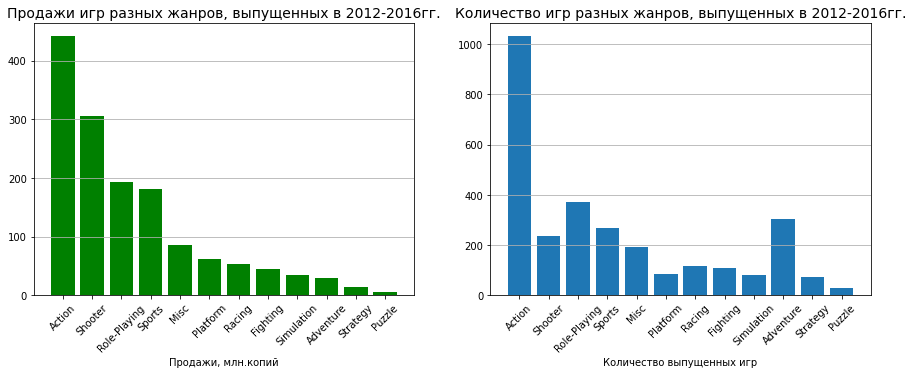

In [24]:
genres_sales = new_data.groupby('genre')['total_sales'].agg(['count','sum','median'])
genres_sales.columns = ['count_games', 'total_sales', 'median_sales']
genres_sales = genres_sales.sort_values(by='total_sales', ascending=False)

plt.figure(figsize=(15,5))
plt.subplot(1,2,2)
plt.bar(genres_sales.index, genres_sales.count_games)
plt.title('Количество игр разных жанров, выпущенных в 2012-2016гг.', size=14)
plt.xticks(rotation=45)
plt.xlabel('Количество выпущенных игр')
plt.grid(axis='y')

plt.subplot(1,2,1)
plt.bar(genres_sales.index, genres_sales.total_sales, color='green')
plt.title('Продажи игр разных жанров, выпущенных в 2012-2016гг.', size=14)
plt.xlabel('Продажи, млн.копий')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

Больше всего суммарных продаж в жанрах **Action, Shooter, Role_Playing, Sports**, что объяснимо, поскольку именно в этих жанрах вышло больше всего игр. Исключение - жанр **Adventure**, где игр вышло много, а продаж мало.

Сравним медианные показатели продаж на игры разных жанров.

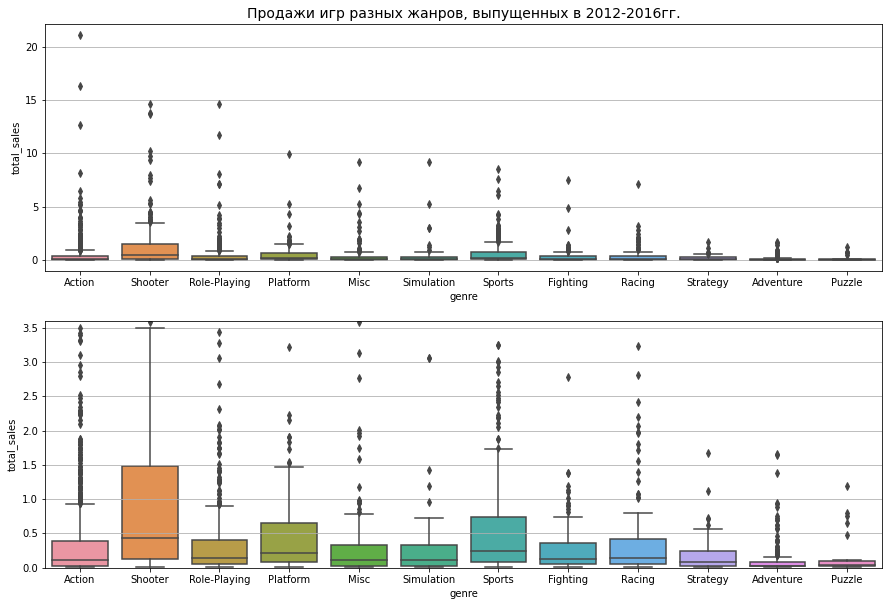

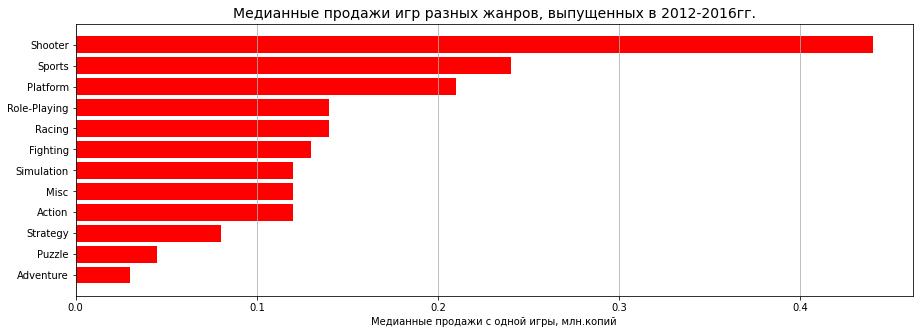

In [25]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
ax = sns.boxplot(data=new_data, x='genre', y='total_sales')
ax.set_title('Продажи игр разных жанров, выпущенных в 2012-2016гг.', size=14)
plt.grid(axis='y')

plt.subplot(2,1,2)
ax = sns.boxplot(data=new_data, x='genre', y='total_sales')
plt.ylim(0,3.6)
plt.grid(axis='y')

plt.figure(figsize=(15,5))
plt.barh(genres_sales.sort_values(by='median_sales').index, 
         genres_sales.sort_values(by='median_sales').median_sales,
         color='red')
plt.title('Медианные продажи игр разных жанров, выпущенных в 2012-2016гг.', size=14)
plt.xlabel('Медианные продажи с одной игры, млн.копий')
plt.grid(axis='x')
plt.show()

Самый эффективный с точки зрения продаж жанр - **Shooter**, мединные продажи - примерно 450млн. копий с игры.

Жанры **Platform, Sports** - следующие по эффективности продаж, здесь медиана - 200 и 250тыс.копий на одну игру, соответственно.

Наименьшим спросом пользуются игры жанров - **Strategy, Puzzle, Adventure**, медианные продажи - менее 100тыс.копий на игру.

Медианные показатели продаж остальных жанров сопоставимы и составляют 120-150тыс. проданных копий на игру.

### Выводы по исследовательскому анализу

1. По динамике количества выпускаемых игр:
* Количество выпускаемых игр начало существенно расти с 1995 года, наибольшее количество выпущено в 2000-х, с 2010 года – спад и к 2012 году стабилизация на уровне 500-600 игр в год. 
* Для исследования выбран период с 2012 года, когда количество выпускаемых игр стабилизировалось
2. По динамике спроса на платформы:
* «Жизненный цикл» спроса на наиболее популярные платформы составляет около 10 лет: около 4-5 лет - рост, 2-3 года – стабильный пик спроса, далее постепенное снижение на протяжении 5-6 лет
* PC – платформа с небольшим, но самым стабильным спросом
* Самые перспективные платформы с точки зрения общего количества продаж – PS4, пришедшая в 2014 году на замену всё ещё популярной PS3, а также XOne, спрос на которую пока также растёт.
* Игры на платформах **3DS, WiiU, X360** отличаются высокими суммарными продажами, но их динамика уже несколько лет отрицательная, жизненный цикл подходит к концу.
3. По влиянию отзывов на продажи:
* Корреляция продаж и оценок пользователей отсутствует. Есть средняя положительная корреляция оценок игр критиками и объёмов их продаж. Возможно, это связано с тем, что покупатели при принятии решения о покупке всё же в какой-то мере ориентируются на мнение критиков. Впрочем, возможно и обратное, что критики часто достаточно объективно оценивают потенциал игры на рынке.
4. По популярности жанров:
* Больше всего суммарных продаж в жанрах **Action, Shooter, Role_Playing, Sports**, что объяснимо, поскольку именно в этих жанрах вышло больше всего игр. Исключение - жанр **Adventure**, где игр вышло много, а продаж мало.
* Самый эффективный с точки зрения продаж жанр - **Shooter**, медианные объёмы продаж - примерно 450млн. копий с игры. Жанры **Platform, Sports** - следующие по эффективности продаж, здесь медиана - 200 и 250тыс.копий на одну игру, соответственно. Наименьшим спросом пользуются игры жанров - **Strategy, Puzzle, Adventure**, медианные продажи - менее 100тыс.копий на игру. Медианные показатели продаж остальных жанров сопоставимы и составляют 120-150тыс. проданных копий на игру.


## Портрет пользователя по регионам

### Топ-5 популярных жанров в регионах 

Выведем мединные продажи игр каждого жанра по регионам.

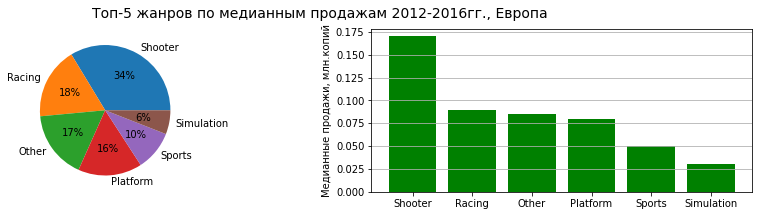

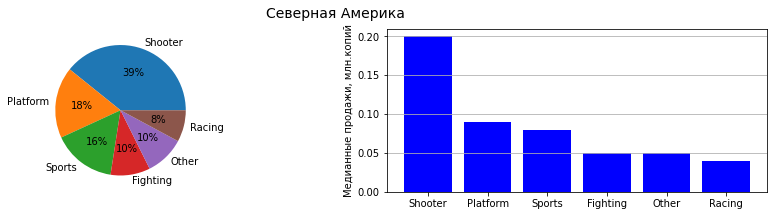

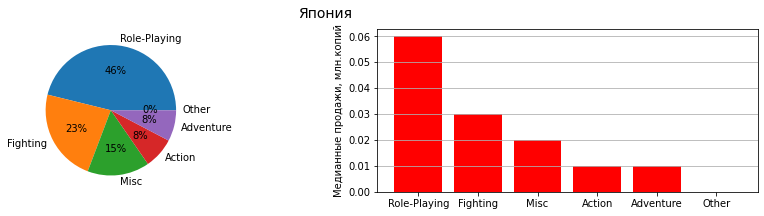

In [26]:
def pie_bar_plots(group, col, title, clr='Green', numtop=5):
    df_sales = (new_data.groupby(group)
                    .agg({col:'median'})
                    .sort_values(by=col, ascending=False)
                    .reset_index()
                   )
    df_sales.iloc[(numtop):,0] = 'Other'
    df_sales = df_sales.groupby(group).agg({col:'sum'}).sort_values(by=col,ascending=False)
    
    plt.figure(figsize=(15,3))
    plt.suptitle(title, fontsize=14)
    plt.subplot(1,2,1)
    plt.pie(df_sales[col], labels=df_sales.index, normalize=True, autopct='%1.0f%%')
    plt.subplot(1,2,2)
    plt.bar(df_sales.index, df_sales[col], color=clr)
    plt.ylabel('Медианные продажи, млн.копий')
    plt.grid(axis='y')
    plt.show()

pie_bar_plots('genre', 'eu_sales', 'Топ-5 жанров по медианным продажам 2012-2016гг., Европа')
pie_bar_plots('genre', 'na_sales', 'Северная Америка', clr='Blue')
pie_bar_plots('genre', 'jp_sales', 'Япония', clr='Red')

Первое место по полуряности жанров в Европе и Америке - жанр **Shooter**, доля спроса - 34% в Европе и 39% в Америке.

Второе по популярности в Европе занимает жанр **Raicing**, в то время как в Северной Америке этот жанр на пятом месте.
Жанр **Platform** одинаково популярен в Европе и Северной Америке, занимая 16% спроса в Европе и 18% в Америке. Затем следует жанр **Sports**, более популярный в Северной Америке (10% спроса) и чуть менее в Европе(16%).

Иначе распределяются медианные продажи в Японии. Здесь лучше всего покупают игры жанра **Role-Playing**, 46% от спроса среди других популярных жанров. На втором месте - **Fighting** (23%), далее - **Misc** (15%) и в равной степени **Action** и **Adventure** (по 8%)

### Топ-5 популярных платформ в регионах 

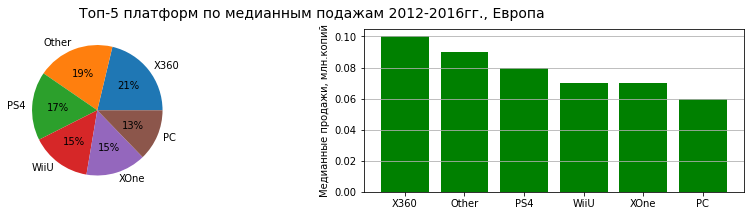

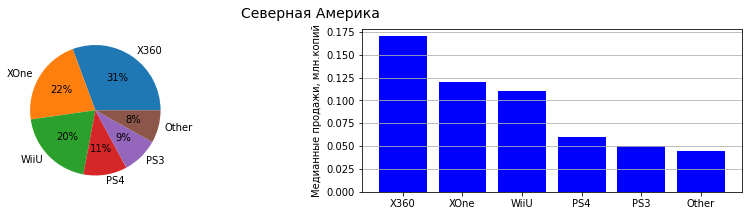

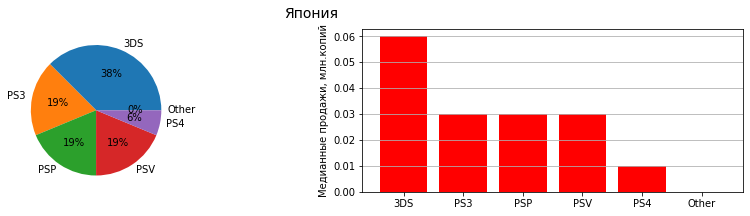

In [27]:
pie_bar_plots('platform', 'eu_sales', 'Топ-5 платформ по медианным подажам 2012-2016гг., Европа')
pie_bar_plots('platform', 'na_sales', 'Северная Америка', 'Blue')
pie_bar_plots('platform', 'jp_sales', 'Япония', 'Red')

В Европе и Америке наибольшим медианным спросом пользуются игры на платформе **X360**, доля продаж среди популярных платформ - 21% и 31%, соответстсвенно. 

На втором месте - **PS4** в Европе (17%), в то время как в Америке эта платформа занимает четвёртое место по популярности (11% в топе). 

Напротив, **XOne** более популярная в Америке (22%) и менее - в Европе (15%). Платфрма WiiU - на третьем месте, одинаково популярна в Европе и Америке. 

Пятое место занимает **PC** в Европе и **PS3** в Америке.

В Японии популярность платформ распределяется по-другому: лидирующие позиции - у платформы **3DS** (доля спроса 38%), затем одинаковыми медианными продажами с игры обладают платформы **PS3, PSP, PSV** и на пятом месте **PS4**.

Как видно, Япония отстаёт от остальных регионов по современности платформ: платформа **3DS**, как мы наблюдали ранее, постепенно уходит с рынка, здесь же в ближайшие годы ещё точно будет пользоваться популярностью. В то же время, популярная в других региоах **PS4** только начала приходить в Японию и, вероятно, скоро её популярность возрастёт и здесь, начав отбирать долю у **PS3**.

### Влияние на продажи рейтинга ESRB

Посмотрим, как влияет на продажи рейтинг ESRB.

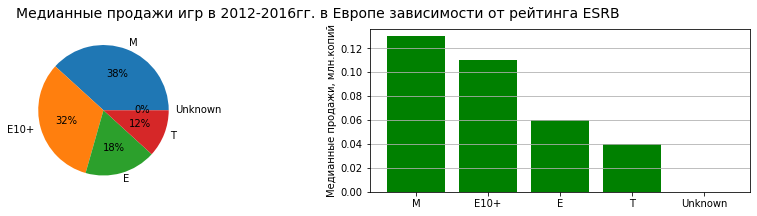

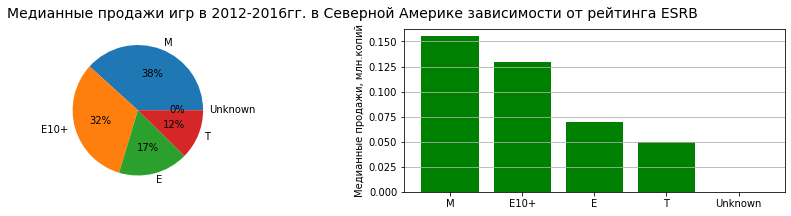

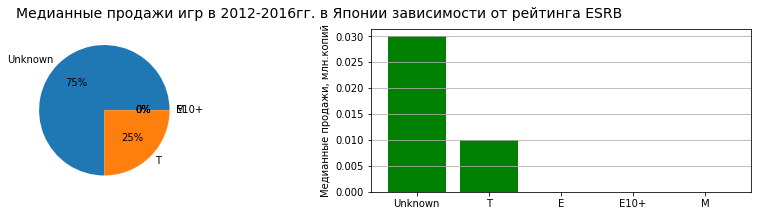

In [28]:
pie_bar_plots('rating', 'eu_sales', 'Медианные продажи игр в 2012-2016гг. в Европе зависимости от рейтинга ESRB', 
              numtop=len(new_data.rating.unique()))
pie_bar_plots('rating', 'na_sales', 'Медианные продажи игр в 2012-2016гг. в Северной Америке зависимости от рейтинга ESRB', 
              numtop=len(new_data.rating.unique()))
pie_bar_plots('rating', 'jp_sales', 'Медианные продажи игр в 2012-2016гг. в Японии зависимости от рейтинга ESRB', 
              numtop=len(new_data.rating.unique()))

Как видим, в Европе и Америке продаются лучше других игры с рейтингом **М** (для детей от 17 и старше) и **E10+** (для детей старше 10 лет). Игры с рейтингом **E** (для всех возрастов) и **T** (для детей старше 13 лет) пользуюся меньшим спросом.

В Японии большую часть продаж занимают игры без возрастного рейтинга, что логично, поскольку в Японии маркировка игр отсутствует.

In [29]:
# Комментарий ревьюера
temp = new_data.copy()
print(temp.rating.isna().sum(), temp.rating.isna().sum()/len(temp))
temp.rating.value_counts()

0 0.0


Unknown    1275
M           498
T           412
E           395
E10+        306
Name: rating, dtype: int64

## Проверка гипотез

Согласно заданию, нам неободимо проверить следующие гипотезы:
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые, т.е. принадлежат одной генеральной совокупности.
Альтернативная гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC отличаются, т.е. принадлежат разным генеральным совокупностям.

Построим графики распределения пользовательского рейтинга для платформ XBox One и PC:

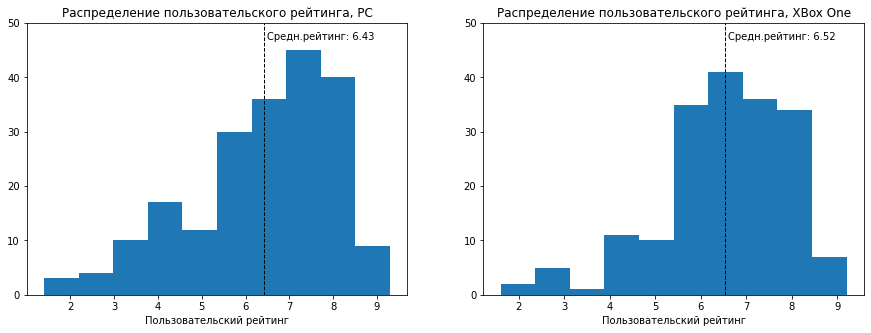

In [30]:
pc_user_scores = new_data.query('platform == "PC" and user_score.notna()').user_score
xone_user_scores = new_data.query('platform == "XOne" and user_score.notna()').user_score

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(pc_user_scores, bins=10)
plt.title('Распределение пользовательского рейтинга, PC')
plt.axvline(pc_user_scores.mean(), color='black', linestyle='dashed', linewidth=1)
plt.text(6.5, 47, f'Средн.рейтинг: {round(pc_user_scores.mean(), 2)}')
plt.ylim(0,50)
plt.xlabel('Пользовательский рейтинг')

plt.subplot(1,2,2)
plt.hist(xone_user_scores, bins=10)
plt.title('Распределение пользовательского рейтинга, XBox One')
plt.axvline(xone_user_scores.mean(), color='black', linestyle='dashed', linewidth=1)
plt.text(6.6, 47, f'Средн.рейтинг: {round(xone_user_scores.mean(), 2)}')
plt.xlabel('Пользовательский рейтинг')
plt.ylim(0,50)
plt.show()

Проведём тест Стюдента для двух выборок:

In [31]:
alpha = 0.01
results = scipy.stats.ttest_ind(pc_user_scores, xone_user_scores)
print('P-Value:', results.pvalue)
if results.pvalue < alpha:
    print('P-value ниже порогового значения, отвергаем нулевую гипотезу')
else:
    print('P-Value выше порогового, нет оснований отвергнуть нулевую гипотезу')

P-Value: 0.5535080500643661
P-Value выше порогового, нет оснований отвергнуть нулевую гипотезу


Таким образом, считаем верной гипотезу о равенстве средних пользовательских рейтингов платформ **Xbox One и PC**.

### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Нулевая гипотеза: Средние пользовательские рейтинги жанров **Action и Sports** одинаковые, то есть выбрки принадлежат к одной генеральной совокупности.\
Альтернативная гипотеза: Средние пользовательске рейтинги жанров **Acion и Sports** разные, то есть выборки принадлежат к разным генеральным совокупностям.

Построим графики распределения пользовательского рейтинга для жанров **Action и Sports**:

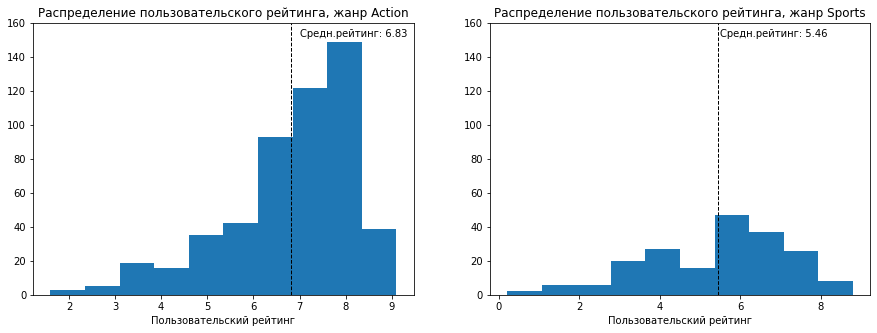

In [32]:
action_user_scores = new_data.query('genre == "Action" and user_score.notna()').user_score
sports_user_scores = new_data.query('genre == "Sports" and user_score.notna()').user_score

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(action_user_scores, bins=10)
plt.title('Распределение пользовательского рейтинга, жанр Action')
plt.axvline(action_user_scores.mean(), color='black', linestyle='dashed', linewidth=1)
plt.text(7, 152, f'Средн.рейтинг: {round(action_user_scores.mean(), 2)}')
plt.ylim(0,160)
plt.xlabel('Пользовательский рейтинг')

plt.subplot(1,2,2)
plt.hist(sports_user_scores, bins=10)
plt.title('Распределение пользовательского рейтинга, жанр Sports')
plt.xlabel('Пользовательский рейтинг')
plt.axvline(sports_user_scores.mean(), color='black', linestyle='dashed', linewidth=1)
plt.text(5.5, 152, f'Средн.рейтинг: {round(sports_user_scores.mean(), 2)}')
plt.ylim(0,160)
plt.show()

Количество наблюдений во второй выборке меньше, что, впрочем, не мешает применить t-китерий Стьюдента для двух выборок.

In [33]:
alpha = 0.01
results = scipy.stats.ttest_ind(action_user_scores, sports_user_scores)
print('P-Value:', results.pvalue)
if results.pvalue < alpha:
    print('P-value ниже порогового значения, отвергаем нулевую гипотезу')
else:
    print('P-Value выше порогового, нет оснований отвергнуть нулевую гипотезу')

P-Value: 3.7163089460934874e-26
P-value ниже порогового значения, отвергаем нулевую гипотезу


Поскольку нулевая гипотеза отвергнута, считаем верной альтернативную ей гипотезу о том, что средние пользовательские рейтинги жанров **Action и Sports** разные.

## Общие выводы

1. Замечания к исходному датасету:
* В названиях столбцов использованы оба регистра. В исследовании для приведения стиля к *snake_case* называния столбцов приведены к нижнему регистру.
* Для двух игр не указаны название и жанр. В исследовании они не учитывались.
* В столбце с годом выпуска пропущены 269 значений. В исследовании они так же не учитывались. 
* Столбец с пользовательским рейтингом помимо пропусков содержит текстовые значения “tbd”, по всей видимости равнозначные отсутствию рейтинга. Текстовые значения мешают единству типа данных в данном столбце. 
* В половине игр в датасете отсутствуют оценки экспертов или пользовательский рейтинг.
* В датасете содржалась игра на платформе **"DS"** 1985 года выпуска, но данная платформа выпущена только в 2004 году.

2. По динамике количества выпускаемых игр:
* Количество выпускаемых игр начало существенно расти с 1995 года, наибольшее количество выпущено в 2000-х, с 2010 года – спад и к 2012 году стабилизация на уровне 500-600 игр в год. 
* Для исследования выбран период с 2012 года, когда количество выпускаемых игр стабилизировалось
3. По динамике спроса на платформы:
* «Жизненный цикл» спроса на наиболее популярные платформы составляет около 10 лет: около 4-5 лет - рост, 2-3 года – стабильный пик спроса, далее постепенное снижение на протяжении 5-6 лет
* PC – платформа с небольшим, но самым стабильным спросом
* Самые перспективные платформы с точки зрения общего количества продаж – **PS4**, пришедшая в 2014 году на замену всё ещё популярной **PS3**, а также **XOne**, спрос на которую пока также растёт.
* Игры на платформах **3DS, WiiU, X360** отличаются высокими суммарными продажами, но их динамика уже несколько лет отрицательная, жизненный цикл подходит к концу.
4. По влиянию отзывов на продажи:
* Корреляция продаж и оценок пользователей отсутствует. Есть средняя положительная корреляция оценок игр критиками и объёмов их продаж. Возможно, это связано с тем, что покупатели при принятии решения о покупке всё же в какой-то мере ориентируются на мнение критиков. Впрочем, возможно и обратное, что критики часто достаточно объективно оценивают потенциал игры на рынке.
5. По популярности жанров:
* Больше всего суммарных продаж в жанрах **Action, Shooter, Role_Playing, Sports**, что объяснимо, поскольку именно в этих жанрах вышло больше всего игр. Исключение - жанр **Adventure**, где игр вышло много, а продаж мало.
* Самый эффективный с точки зрения продаж жанр - **Shooter**, медианные объёмы продаж - примерно 450млн. копий с игры. Жанры **Platform, Sports** - следующие по эффективности продаж, здесь медиана - 200 и 250тыс.копий на одну игру, соответственно. Наименьшим спросом пользуются игры жанров - **Strategy, Puzzle, Adventure**, медианные продажи - менее 100тыс.копий на игру. Медианные показатели продаж остальных жанров сопоставимы и составляют 120-150тыс. проданных копий на игру.
6. По популярности жанров по регионам исходя из медианных продаж на одну игру:
* Первое место по полуряности жанров в Европе и Америке - жанр **Shooter**, доля спроса - 34% в Европе и 39% в Америке.

* Второе по популярности в Европе занимает жанр **Raicing**, в то время как в Северной Америке этот жанр на пятом месте.
* Жанр **Platform** одинаково популярен в Европе и Северной Америке, занимая 16% спроса в Европе и 18% в Америке. Затем следует жанр **Sports**, более популярный в Северной Америке (10% спроса) и чуть менее в Европе(16%).

* Иначе распределяются медианные продажи в Японии. Здесь лучше всего покупают игры жанра **Role-Playing**, 46% от спроса среди других популярных жанров. На втором месте - **Fighting** (23%), далее - **Misc** (15%) и в равной степени **Action** и **Adventure** (по 8%)

7. По популярности платформ по регионам исходя из медианных продаж на игру:
* В Европе и Америке наибольшим медианным спросом пользуются игры на платформе **X360**, доля продаж среди популярных платформ - 21% и 31%, соответстсвенно. 

* На втором месте - **PS4** в Европе (17%), в то время как в Америке эта платформа занимает четвёртое место по популярности

* Напротив, **XOne** более популярная в Америке (22%) и менее - в Европе (15%). Платфрма WiiU - на третьем месте, одинаково популярна в Европе и Америке. 

* Пятое место занимает **PC** в Европе и **PS3** в Америке.

* В Японии популярность платформ распределяется по-другому: лидирующие позиции - у платформы **3DS** (доля спроса 38%), затем одинаковыми медианными продажами с игры обладают платформы **PS3, PSP, PSV** и на пятом месте **PS4**.

* Как видно, Япония отстаёт от остальных регионов по современности платформ: платформа **3DS**, как мы наблюдали ранее, постепенно уходит с рынка, здесь же в ближайшие годы ещё точно будет пользоваться популярностью. В то же время, популярная в других региоах **PS4** только начала приходить в Японию и, вероятно, скоро её популярность возрастёт и здесь, начав отбирать долю у **PS3**.
8. По влиянию возрастного рейтинга на продажи:
* Как видим, в Европе и Америке продаются лучше других игры с рейтингом **М** (для детей от 17 и старше) и **E10+** (для детей старше 10 лет). Игры с рейтингом **E** (для всех возрастов) и **T** (для детей старше 13 лет) пользуюся меньшим спросом.
* В Японии большую часть продаж занимают игры без возрастного рейтинга, что логично, поскольку в Японии маркировка игр отсутствует.
9. По гипотезам:
* Принимаем гипотезу о равенстве средних пользовательских рейтингов платформ **Xbox One и PC**.
* Принимаем гипотезу о том, что средние пользовательские рейтинги жанров **Action и Sports** разные, причём средние рейтинги жанра Sports ниже.

###  **Итоговые рекомендации по выбору игр для продвижения:**
* **Для Европы**:  Платформы - **PS4** и **X360** (но готовиться к тому, что через какое-то время последнюю сменит набирающая попуярность **XOne** ). Жанры - **Shooter** и **Racing**
* **Для Северной Америки**: Платформы - **X360** и **XOne**, жанры - **Shooter**, **Platform** и **Sports**.
* **Для Японии**: Платформа - **3DS**, жанры - **Role_Playing** и **Fighting**
* По рейтингу **ESRB**: **M**, **E10+**, при этом не ориентируемся на этот рейтинг в Японии.
* Не обращаем внимания на пользовательский рейтинг игр, при этом стоит в некоторой степени ориентироваться на рейтинг критиков.